## Station descriptors

**diff**: for each station, array containing the difference between consecutive phase delay values station


| name  | description  | normalization  |
|:-:|:-:|:-:|
|d_max  | Maximum diff value during all the event |   |
|d_outliers| Number of diff points out of +/- 2*sigma* ||
|d_outliers_bin  | Binary for diff values out of +/- 2*sigma* |   |
|d_var| diff variance during all the event||
|i_outf_ma| Outlier factor from Moving Average method||
|i_outf_pf| Outlier factor from Polynomial fit method||
|i_range| Maximum phase delay minus Minimum phase delay||
|n| Number of epochs ||
|nr| Number of epochs / Max number of epochs for the event||
|sroti  | Scintillation index: a ROTI-like indicator: get_sroti(data) |   |
 	 	 	 	 	 	 	 	 	 	

## Event descriptors

**diff**: for each station, array containing the difference between consecutive phase delay values station

| name | description | normalization/aggregation |
| :-:|:-:|:-: |
| d_max_diff | *Maximum diff value* difference between two largest stations  | max - max_2  |
| d_max_std | Maximum diff value during all the event |  std |
| d_outliers | Number of diff points out of +/- 2*sigma* | sum |
| d_outliers_bin | Binary for diff values out of +/- 2*sigma* | sum  |
| d_var | diff variance during all the event| std |
| n | Number of epochs |  sum |
| n_low | Number of stations with fewer than L/2 observations, where L is the max number of observations possible| NA |
| n_low_r | Fractional Number of stations with fewer than L/2 observations, where L is the max number of observations possible. The fraction is calculated w.r.t. the number of stations| NA |
| n_st | Number of stations| NA |
| nr | Number of epochs / Max number of epochs for the event| sum |
| i_outf_ma | Outlier factor from Moving Average method| std |
| i_outf_pf | Outlier factor from Polynomial fit method| std |
| i_range | Maximum phase delay minus Minimum phase delay| std |
| sm_mean | Mean similitude between pairs of stations data (three lower similarities)| NA |
| sm_std | Standard deviation of similitude indicator between station pairs| NA |
| sroti_max | Max of Scintillation index, a ROTI-like indicator: get_sroti(data) |  max |
| sroti_mean | Mean of Scintillation index, a ROTI-like indicator: get_sroti(data) | mean  |
| sroti_std | Standard Deviation of Scintillation index, a ROTI-like indicator: get_sroti(data) | std  |
| doy | Day of year | Divided by 365 |
| el | Elevation |Divided by 90|
| grad | Gradient value reported |Divided by 100|
| hh | Hour of occurrence |Divided by 24|
| n_pairs | Number of station pairs | NA |


## Time series descriptors

The time series descriptors are presented this way:

**station -> time_slot -> descriptors**

So, this is a cube of dimension n_stations x n_time_slots x n_features. For each station / time_slot, it is defined:

| name  | description  | values  |
|:-:|:-:|:-:|
|d_kur| diff kurtosis during the time window||
|d_max  | Maximum diff value during during the time window |   |
|d_ske| diff skewness during the time window||
|d_var| diff variance during the time window||
|d_outliers| Number of diff points out of +/- 2*sigma* during the time window. *sigma* is calculated for all the event  ||
| d_outliers_bin  | Binary for diff values out of +/- 2*sigma* during the time window. *sigma* is calculated for all the event   |   |
|i_range| Maximum phase delay minus Minimum phase delay during the time window||
| n| Number of epochs during the time window||
| n_i_out_ma  | Number of outliers in phase delay with the moving average method |   |
| n_i_out_pf  | Number of outliers in phase delay with the polyfit method   |   |
| nr| Number of epochs / Max number of epochs for the event||
| sroti  | Scintillation index: a ROTI-like indicator: get_sroti(data) |   |


In [1]:
from plotly.offline import init_notebook_mode
from descriptors import *
from utils_ml import *
init_notebook_mode()
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
year = 2013
Plots_folder = "/mnt/gnss/data/regme/Plots_regme/PlotsCorr"+str(year)

In [3]:
hdf = HDFStore('/mnt/gnss/data/regme/gradients/data2013.h5')
event  = hdf["event"]
curve  = hdf["gradient"]
detail = hdf["detail"]
hdf.close()

In [4]:
event.shape, curve.shape, detail.shape

((6529, 14), (81603, 15), (9242323, 14))

In [5]:
#ev_class = pd.read_csv("data/ev_types.csv")
ev_class = pd.read_csv("data/events_classes_July20th.csv")
print ev_class.shape
ev_class.head()


(402, 3)


,eid,valid_event,scint
0,12,True,True
1,13,True,True
2,45,True,True
3,46,True,True
4,64,True,True


### Check an event

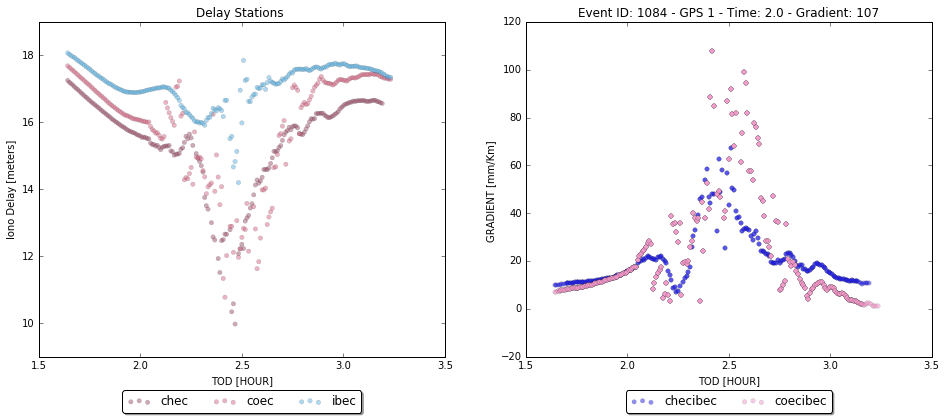

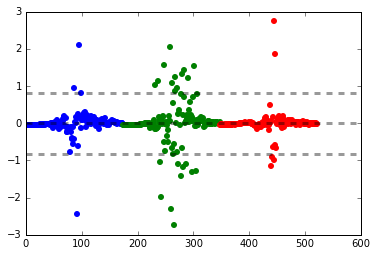

In [108]:
inspect_event(event, curve, detail, 1084,  Plots_folder) #384
res = analyze_set(event, curve, detail, 1084, Plots_folder, tw = 6, plot=False)
tsd = res[1]
plot_data = []
columns = tsd.columns.difference(["station","time_slot"])
columns = ["d_max","n_out_ma","n_out_pf","i_range","d_outliers","d_outliers_bin"]
for st in tsd.station.unique():
    d  = tsd[tsd.station==st]
    plot_data += [ go.Scatter(x=range(d.time_slot.unique().shape[0]), y=d[column].values, 
                         name=column+" "+st, mode="markers+lines", opacity=.5) 
             for column in columns]
iplot(go.Figure(data=plot_data)) 



### Create dataframe with descriptors for each event

In [131]:
print time.ctime()
start = time.time()
data = []
ts_data = []
df = {}
ad = {}
ts = {}
sm = {}
columns = ["d_max","n_out_ma","n_out_pf","i_range","d_outliers","d_outliers_bin"]
max_len = 20*len(columns)*23 # Max number of stations * Number of descriptors * Time slots
for i, plot in ev_class[0:2].iterrows():
    print "event id:", plot.eid, ", is valid:", plot.valid_event
    res = analyze_set(event, curve, detail, plot.eid, Plots_folder, tw = 6, plot=False)
    df[i],ts[i],sm[i],ad[i] = res[0], res[1], res[2], res[4]
    data.append( list([plot.eid]) + list(ad[i].values.flatten()) + list([plot.valid_event]) )
    ts_row = []
    for j, st in enumerate(ts[i].station.unique()):
        if j>19:
            print "Exceeded number of stations for event"
            continue
        for column in columns:
            st_col_data = (ts[i])[(ts[i]).station==st][column]
            ts_row += list(st_col_data.values.flatten())
    if len(ts_row)<max_len:
        ts_row = ts_row + [0]*(max_len - len(ts_row))
    ts_data.append( list([plot.eid]) + ts_row + list([plot.valid_event]) )

data = np.array(data)
ts_data = np.array(ts_data)

columns = list(["eid"]) + list(ad[0].columns) + list(["label"])
data = pd.DataFrame(data,columns=columns)
end = time.time()

Fri Jul 22 06:35:44 2016
event id: 12 , is valid: True
event id: 13 , is valid: True


In [138]:
event.ix[5233]["PAIRS"]#[event.N_PAIRS>20]

"['alec cuec' 'alec erec' 'alec maec' 'alec riop' 'chec ibec' 'chec quem'\n 'clec ljec' 'clec mhec' 'coec ibec' 'cuec gzec' 'cuec njec' 'erec maec'\n 'erec prec' 'gyec njec' 'gyec pjec' 'gzec ljec' 'ibec quem' 'ljec pdec'\n 'maec prec' 'maec riop' 'mhec njec' 'pjec seec' 'prec riop']"

In [ ]:
print time.ctime()
start = time.time()
data = []
ts_data = []
df = {}
ad = {}
ts = {}
sm = {}
max_len = 20*6*23 # Max number of stations * Number of descriptors * Time slots
for i, plot in ev_class.iterrows():
    print "event id:", plot.eid, ", is valid:", plot.valid_event
    res = analyze_set(event, curve, detail, plot.eid, Plots_folder, tw = 6, plot=False)
    df[i],ts[i],sm[i],ad[i] = res[0], res[1], res[2], res[4]
    data.append( list([plot.eid]) + list(ad[i].values.flatten()) + list([plot.valid_event]) )
    ts_row = []
    for j, st in enumerate(ts_data.station.unique()):
        if j>19:
            print "Exceeded number of stations for event"
            continue
        for column in columns
            st_col_data = ts_data[ts_data.station==st][column]
            ts_row += list(st_col_data.values.flatten())
    if len(ts_row)<max_len:
        ts_row = ts_row + [0]*(maxLen - len(ts_row))
    ts_data.append( list([plot.eid]) + ts_row + list([plot.valid_event]) )

data = np.array(data)
ts_data = np.array(data)

columns = list(["eid"]) + list(ad[0].columns) + list(["label"])
data = pd.DataFrame(data,columns=columns)
end = time.time()

Wed Jul 20 11:11:37 2016
event id: 12 , is valid: True
event id: 13 , is valid: True
event id: 45 , is valid: True
event id: 46 , is valid: True
event id: 64 , is valid: True
event id: 65 , is valid: True
event id: 75 , is valid: False
event id: 76 , is valid: False
event id: 87 , is valid: True
event id: 88 , is valid: False
event id: 96 , is valid: False
event id: 117 , is valid: True
event id: 120 , is valid: True
event id: 122 , is valid: False
event id: 129 , is valid: False
event id: 133 , is valid: True
event id: 134 , is valid: True
event id: 137 , is valid: True
event id: 138 , is valid: True
event id: 139 , is valid: True
event id: 140 , is valid: False
event id: 141 , is valid: True
event id: 142 , is valid: True
event id: 144 , is valid: True
event id: 145 , is valid: True
event id: 169 , is valid: False


In [ ]:
print "Total time:", end - start

In [139]:
data_ori.describe()
data = data_ori.copy()

In [92]:
for col in data.columns:
    print col, "\t\t", data[col].describe()["std"]

eid 		1844.56960161
bpoints_out 		2.98512939522
diff_max_diff 		0.356732087194
diff_max_std 		0.1427301639
diff_var 		0.149194828081
n 		2.00646436088
n_low 		2.51719027544
n_low_r 		0.0
n_st 		2.51719027544
nr 		2.06148161143
of_ma 		0.136151743113
of_pf 		0.14746725662
points_out 		2.16211034823
sm_mean 		2.62605577625
sm_std 		1.67790176582
sroti_max 		3.15630344055
sroti_mean 		1.04365972605
sroti_std 		1.68466717732
val_range 		0.133773488598
n_pairs 		2.34374000413
doy 		0.286296451429
hh 		0.338437515951
el 		0.127148498515
label 		0.431736619628


In [41]:
data[["sm_mean","sm_std"]].describe()

,sm_mean,sm_std
count,401.000000,401.000000
mean,3.555498,1.903767
std,2.626056,1.677902
min,0.349718,0.075465
25%,2.097391,0.818018
50%,2.762275,1.424779
75%,4.196053,2.320902
max,21.047401,11.294265


In [ ]:
data_ori = data.copy()

In [141]:
data = data.drop(183)
data.shape

(401, 24)

In [ ]:
%autoreload 2
from utils_ml import *

In [142]:
#ml_col = ["eid","sim_mean","sim_std","label"]
#data = data_ori.copy()
ml_col = data.columns
ml_col = ['eid', 
          'bpoints_out', 'diff_max_std', 'diff_var', 'n', 'n_low', #'n_low_r',
          'n_st', 'nr', 'of_ma', 'of_pf', 'points_out', 
          'sm_mean', 'sm_std',
          'sroti_max', 'sroti_mean', 'sroti_std', 'val_range',
          'n_pairs', 'doy', 'hh', 'el',
          'label']

train, test = train_test_split(data[ml_col], test_size=.3, random_state=123)
train_ind, test_ind = train[:,0], test[:,0]
train_target, test_target  = train[:,-1], test[:,-1]

train = train[:,1:-1]
test  = test[:,1:-1]

train_mean, train_std = train.mean(axis=0), train.std(axis=0,ddof=1)
train = (train - train_mean) / train_std
test  = (test  - train_mean) / train_std

In [143]:
np.column_stack((ml_col[1:-1],train_mean,train_std ))

array([['bpoints_out', '3.11071428571', '3.10599366074'],
       ['diff_max_std', '0.422090578529', '0.14081442837'],
       ['diff_var', '0.415651513422', '0.147806946365'],
       ['n', '2.7039484127', '2.06643807825'],
       ['n_low', '4.58214285714', '2.63836508128'],
       ['n_st', '4.58214285714', '2.63836508128'],
       ['nr', '4.06121073166', '2.11301341979'],
       ['of_ma', '0.419695536632', '0.134793442388'],
       ['of_pf', '0.42258474677', '0.146512596159'],
       ['points_out', '2.51657283194', '2.25339883283'],
       ['sm_mean', '3.46887868527', '2.47368971922'],
       ['sm_std', '1.8533835264', '1.56962848672'],
       ['sroti_max', '3.82426790263', '2.94613931453'],
       ['sroti_mean', '1.56014905489', '0.96821001077'],
       ['sroti_std', '1.7074034435', '1.55536369016'],
       ['val_range', '0.27513971487', '0.134237484553'],
       ['n_pairs', '3.23928571429', '2.49225888035'],
       ['doy', '0.192035225049', '0.284816081184'],
       ['hh', '0.37626488

In [144]:
unique, counts = np.unique(train_target, return_counts=True)
print "training set:"
print np.asarray((unique, counts)).T
unique, counts = np.unique(test_target, return_counts=True)
print "test set:"
print np.asarray((unique, counts)).T


training set:
[[   0.  210.]
 [   1.   70.]]
test set:
[[  0.  92.]
 [  1.  29.]]


### Naive bayes classifier

Number of mislabeled points out of a total 280 points : 16


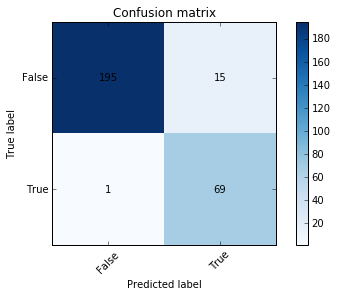

In [145]:
gnb = GaussianNB()
model = gnb.fit(train, train_target)
y_pred = model.predict(train)
print("Number of mislabeled points out of a total %d points : %d" % (train.shape[0],(train_target != y_pred).sum()))
a = np.array(train_target,dtype="b")
b = np.array(y_pred,dtype="b")
cm = confusion_matrix(a,b,labels=[0,1])
plot_confusion_matrix(cm, ["False","True"])

In [146]:
train_ind[y_pred != train_target], train_target[y_pred != train_target]

(array([ 5788.,    76.,  1088.,  5399.,   282.,    96.,   130.,   121.,
          129.,  2688.,  5188.,  1021.,   169.,  1899.,  5899.,  5988.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.]))

Number of mislabeled points out of a total 121 points : 9


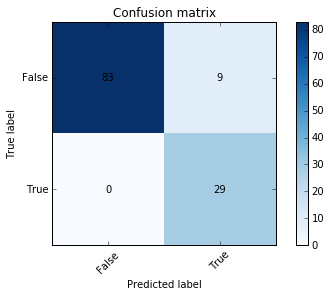

In [147]:
y_pred = model.predict(test)
print("Number of mislabeled points out of a total %d points : %d" % (test.shape[0],(test_target != y_pred).sum()))
a = np.array(test_target,dtype="b")
b = np.array(y_pred,dtype="b")
cm = confusion_matrix(a,b,labels=[0,1])
plot_confusion_matrix(cm, ["False","True"])

In [148]:
test_ind[y_pred != test_target], test_target[y_pred != test_target]

(array([ 1020.,    88.,    88.,  1588.,   122.,  5388.,   167.,    75.,
         4899.]), array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]))

### Clustering

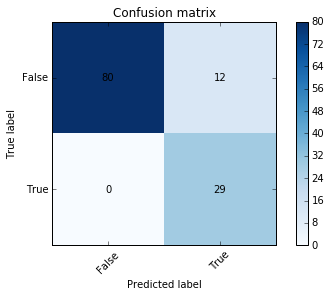

In [150]:
k=2

model = KMeans(n_clusters=k)
model.fit(train)

y_pred = model.predict(test)
a = np.array(test_target,dtype="b")
b = np.array(y_pred,dtype="b")
cm = confusion_matrix(a,b,labels=[0,1])
plot_confusion_matrix(cm, ["False","True"])

File not found /mnt/gnss/data/regme/Plots_regme/PlotsCorr2013/1020.png


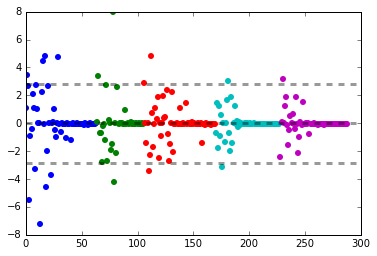

In [63]:
inspect_event(event, curve, detail, 1020,  Plots_folder)

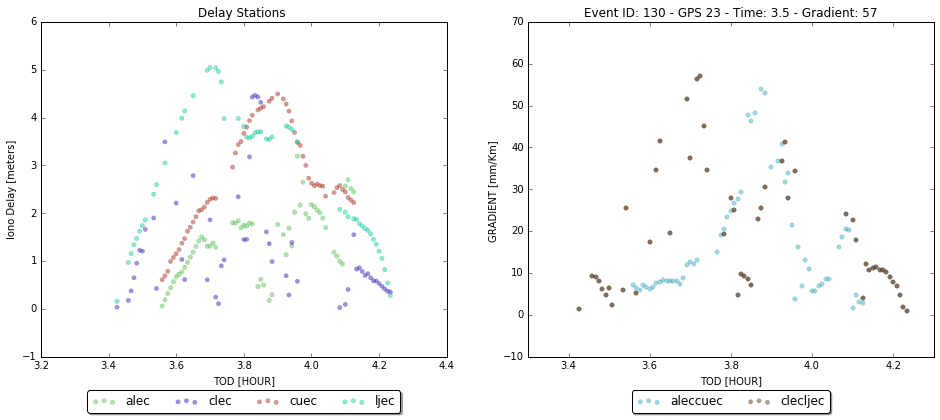

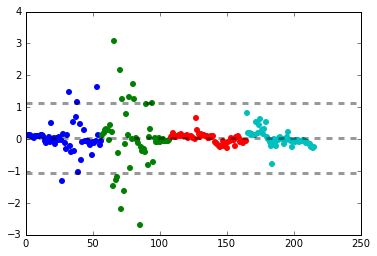

In [97]:
inspect_event(event, curve, detail, 130,  Plots_folder)

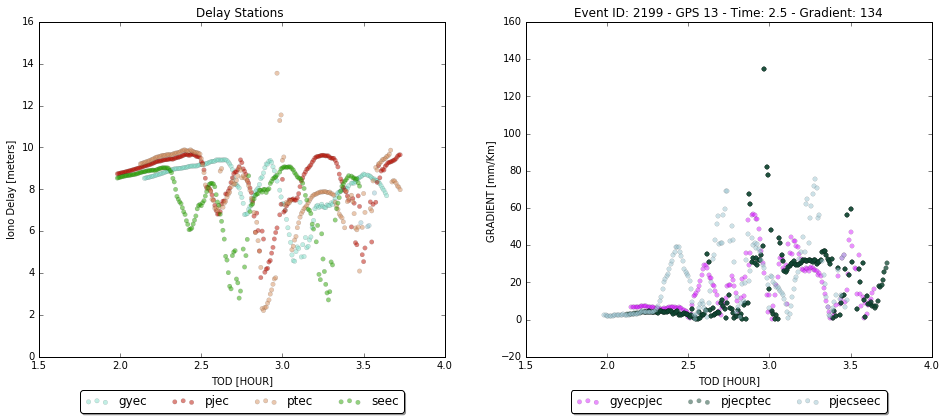

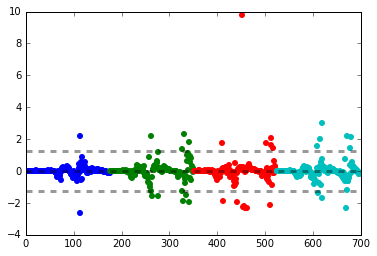

In [64]:
inspect_event(event, curve, detail, 2199,  Plots_folder)

In [67]:
from sklearn.ensemble import RandomForestClassifier

Number of mislabeled points out of a total 280 points : 1


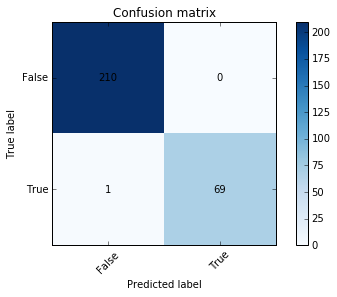

In [151]:
rfc = RandomForestClassifier(n_estimators=10,random_state=123)
model = rfc.fit(train, train_target)
y_pred = model.predict(train)
print("Number of mislabeled points out of a total %d points : %d" % (train.shape[0],(train_target != y_pred).sum()))
a = np.array(train_target,dtype="b")
b = np.array(y_pred,dtype="b")
cm = confusion_matrix(a,b,labels=[0,1])
plot_confusion_matrix(cm, ["False","True"])

Number of mislabeled points out of a total 121 points : 8


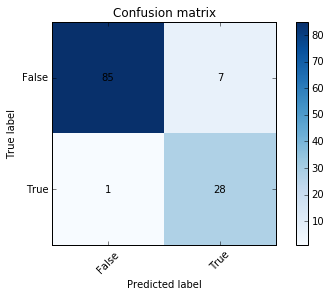

In [152]:
y_pred = model.predict(test)
print("Number of mislabeled points out of a total %d points : %d" % (test.shape[0],(test_target != y_pred).sum()))
a = np.array(test_target,dtype="b")
b = np.array(y_pred,dtype="b")
cm = confusion_matrix(a,b,labels=[0,1])
plot_confusion_matrix(cm, ["False","True"])

In [153]:
fi = pd.DataFrame( {"col": ml_col[1:-1], "feat_imp": model.feature_importances_} )
fi.sort_values(by="feat_imp",ascending=False).head()

,col,feat_imp
8,of_pf,0.224045
1,diff_max_std,0.163278
2,diff_var,0.091150
3,n,0.079577
9,points_out,0.076878


In [154]:
pca = PCA(5)

In [155]:
pca.fit(train)

PCA(copy=True, n_components=5, whiten=False)

In [156]:
pc = pca.components_
pc.shape

(5, 20)

In [157]:
fi = pd.DataFrame( {"col": ml_col[1:-1], 
                    "pc1": pc[0,:],
                    "pc2": pc[1,:],
                    "pc3": pc[2,:],
                    "pc4": pc[3,:],
                    "pc5": pc[4,:]
                   } )
fi.sort_values(by="pc1",ascending=False)

,col,pc1,pc2,pc3,pc4,pc5
9,points_out,0.298779,0.083852,-0.109535,0.025651,-0.013867
0,bpoints_out,0.298528,0.088473,-0.125992,0.019962,-0.053788
6,nr,0.274726,0.132712,-0.253034,0.046860,0.073261
4,n_low,0.274032,0.157748,-0.251743,0.058631,-0.021268
5,n_st,0.274032,0.157748,-0.251743,0.058631,-0.021268
3,n,0.272344,0.084150,-0.149459,0.036127,0.303701
16,n_pairs,0.256124,0.163334,-0.310433,0.066632,0.004023
19,el,0.154158,-0.133682,0.247989,-0.145415,0.844453
17,doy,0.070057,-0.017138,-0.117499,-0.942944,-0.150876
13,sroti_mean,0.051896,0.394878,0.262837,-0.047771,-0.186998
